### Loading the dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving yalefaces.zip to yalefaces.zip


In [2]:
import zipfile
import io

In [3]:
with zipfile.ZipFile(io.BytesIO(uploaded['yalefaces.zip']), 'r') as zip_ref:
    zip_ref.extractall('/content/')

### Assignment 1

In [4]:
import numpy as np

In [5]:
class PCA():
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        covariance = np.cov(X_centered, rowvar=False)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, sorted_indices]
        eigenvalues = eigenvalues[sorted_indices]

        self.components = eigenvectors[:, :self.n_components]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Assignment 2

In [6]:
import os
from PIL import Image

In [7]:
def load_training_images(dataset_path):
    X, y = [], []
    people = sorted(os.listdir(dataset_path))

    for person in people:
        person_folder = os.path.join(dataset_path, person)
        if not os.path.isdir(person_folder) or person == 'test':
            continue

        for filename in os.listdir(person_folder):
            file_path = os.path.join(person_folder, filename)

            try:
                img = Image.open(file_path)
            except Exception as e:
                print(f'Lỗi đọc ảnh {file_path}: {e}')
                continue

            img = img.convert('L')
            img = img.resize((80, 64))

            img_np = np.array(img).astype(np.float32)
            img_vector = img_np.flatten()

            X.append(img_vector)
            y.append(person)

    X, y = np.array(X), np.array(y)
    return X, y

In [8]:
X_train, y_train = load_training_images('/content/yalefaces')

In [9]:
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)

In [10]:
print(X_train_pca.shape)

(150, 20)


In [11]:
import matplotlib.pyplot as plt

In [12]:
def plot_eigenfaces(pca, image_shape):
    eigenfaces = pca.components

    fig, axes = plt.subplots(4, 5, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(20):
        eigenface = eigenfaces[:, i].reshape(image_shape)
        axes[i].imshow(eigenface, cmap='gray')
        axes[i].set_title(f"Eigenface {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

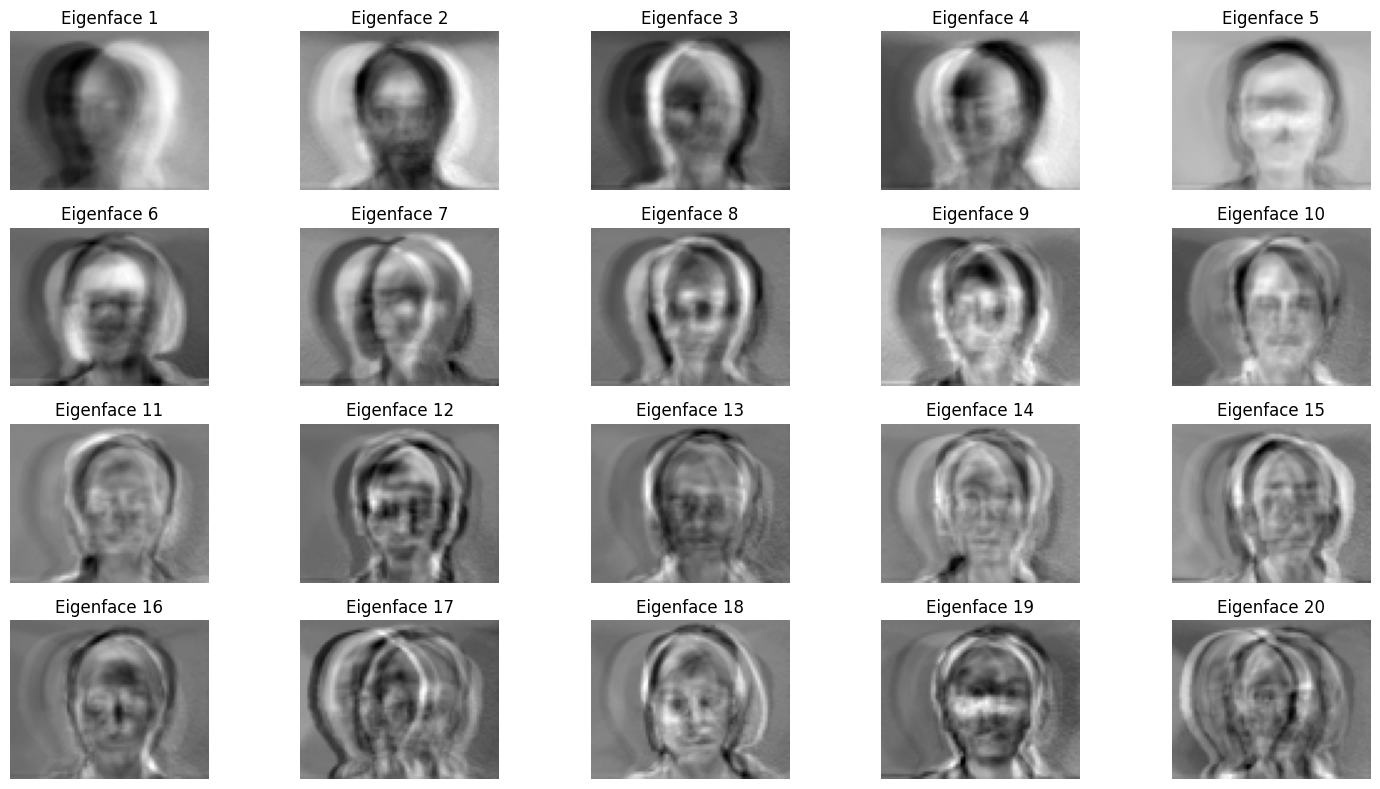

In [13]:
image_shape = (64, 80)
plot_eigenfaces(pca, image_shape)

### Assignment 3

In [14]:
def load_test_images(test_path):
    X_test, y_test = [], []
    test_files = sorted(os.listdir(test_path))

    for filename in test_files:
        file_path = os.path.join(test_path, filename)

        try:
            img = Image.open(file_path)
        except Exception as e:
            print(f'Lỗi đọc ảnh {file_path}: {e}')
            continue

        img = img.convert('L')
        img = img.resize((80, 64))

        img_np = np.array(img).astype(np.float32)
        img_vector = img_np.flatten()

        X_test.append(img_vector)

        label = filename.split('.')[0]
        y_test.append(label)

    X_test, y_test = np.array(X_test), np.array(y_test)
    return X_test, y_test


In [15]:
def predict(X_train_pca, y_train, X_test_pca):
    y_pred = []

    for test_vec in X_test_pca:
        distances = np.linalg.norm(X_train_pca - test_vec, axis=1)
        nearest_idx = np.argmin(distances)
        y_pred.append(y_train[nearest_idx])

    return np.array(y_pred)

In [16]:
def score(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [17]:
X_test, y_test = load_test_images('/content/yalefaces/test')

In [18]:
X_test_pca = pca.transform(X_test)

In [19]:
y_pred = predict(X_train_pca, y_train, X_test_pca)
y_pred

array(['person-1', 'person-10', 'person-11', 'person-12', 'person-13',
       'person-6', 'person-15', 'person-12', 'person-3', 'person-4',
       'person-5', 'person-6', 'person-7', 'person-7', 'person-9'],
      dtype='<U9')

In [20]:
accuracy = score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8
